<a href="https://colab.research.google.com/github/s-neela/neela_INFO5731_spring2021/blob/main/In_Class_exercises_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In class exercise 10 (20 points in total, 4/16/2021)

The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [6]:

import pandas as pd
import gensim
df=pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()
df = df[df['Reviews'].notnull()]
stop = stopwords.words('english')
df['after_punct_less'] = df['Reviews'].str.replace('[^\w\s].#','')
df['after_rm_stopwords'] =df['after_punct_less'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['after_numerics']=df['after_rm_stopwords'].str.replace('[0-9]','')
df['after_lowercasing'] =df['after_numerics'].apply(lambda x: " ".join(x.lower() for x in x.split()))

df['after_stemming']=df['after_lowercasing'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['cleaned_text'] = df['after_stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
df['cleaned_text'].head()

0    i feel lucki found use (phone u & use hard all...
1    nice phone, nice grade pantach revue. veri cle...
2                                            veri plea
3      it work good goe slow sometim good phone i love
4    great phone replac lost phone. the thing volum...
Name: cleaned_text, dtype: object

In [8]:
df_1=(df.sample(n=4000)).reset_index()

In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(df_1['cleaned_text'].values)
tfidf.shape

(4000, 6589)

In [10]:
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 5, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [11]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [12]:
terms1 = tfidf_vect.get_feature_names()
terms1[1:5]
df1 = df_1
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label
0,193246,HTC One M7 32GB Unlocked GSM 4G LTE Android Ce...,HTC,133.95,2.0,it keeps updating and then everything get wipe...,0.0,it keeps updating and then everything get wipe...,keeps updating everything get wipes even type ...,keeps updating everything get wipes even type ...,keeps updating everything get wipes even type ...,keep updat everyth get wipe even type allow up...,keep updat everyth get wipe even type allow up...,4
1,184494,GreatCall Jitterbug5 Easy-to-Use Cell Phone an...,Jitterbug,99.90,2.0,Too small and the flip did not make it easy to...,0.0,Too small and the flip did not make it easy to...,Too small flip make easy use.,Too small flip make easy use.,too small flip make easy use.,too small flip make easi use.,too small flip make easi use.,4
2,17815,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,NaN,99.99,5.0,"Great quality, workes perfectly and looks new.",0.0,"Great quality, workes perfectly and looks new.","Great quality, workes perfectly looks new.","Great quality, workes perfectly looks new.","great quality, workes perfectly looks new.","great quality, work perfectli look new.","great quality, work perfectli look new.",4
3,242250,Moto G Play (4th gen.) - Black - 16 GB - Unlocked,NaN,149.00,5.0,"I really wanted to do a review for this phone,...",6.0,"I really wanted to do a review for this phone,...","I really wanted review phone, everything Galax...","I really wanted review phone, everything Galax...","i really wanted review phone, everything galax...","i realli want review phone, everyth galaxi s d...","i realli want review phone, everyth galaxi s d...",4
4,84567,BlackBerry 8520OEMRED Gemini 8520 Unlocked Pho...,BlackBerry,39.99,5.0,It's a really good price for an unlocked black...,0.0,It's a really good price for an unlocked black...,"It's really good price unlocked blackberry, es...","It's really good price unlocked blackberry, es...","it's really good price unlocked blackberry, es...","it' realli good price unlock blackberry, espec...","it' realli good price unlock blackberry, espec...",4


In [13]:
df1.groupby(['Tfidf Clus Label'])['cleaned_text'].count()

Tfidf Clus Label
0     170
1     166
2     192
3     189
4    3283
Name: cleaned_text, dtype: int64

In [14]:
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(1,5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 1: love
 it
 phone
 great
 new
Cluster 2: good
 veri
 phone
 product
 it
Cluster 3: excel
 excelent
 product
 seller
 recommend
Cluster 4: phone
 it
 work
 good
 the


In [15]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import gensim

In [16]:
i=0
list_of_sent=[]
for sent in df_1['cleaned_text'].values:
    list_of_sent.append(sent.split())

In [17]:
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(4000, 100)

In [18]:
# Computing 200th Nearest neighbour distance
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199]

In [22]:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

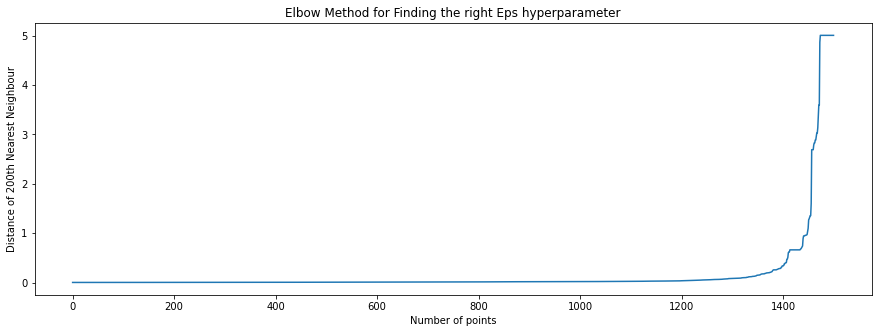

In [26]:
plt.figure(figsize=(15,5))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In one paragraph, please compare K means, DBSCAN and Hierarchical clustering. 

In [27]:
model = DBSCAN(eps = 8, min_samples = minPts, n_jobs=-2)
model.fit(sent_vectors)
df_1['AVG-W2V Clus Label'] = model.labels_
df_1.head(2)


,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label,AVG-W2V Clus Label
0,193246,HTC One M7 32GB Unlocked GSM 4G LTE Android Ce...,HTC,133.95,2.0,it keeps updating and then everything get wipe...,0.0,it keeps updating and then everything get wipe...,keeps updating everything get wipes even type ...,keeps updating everything get wipes even type ...,keeps updating everything get wipes even type ...,keep updat everyth get wipe even type allow up...,keep updat everyth get wipe even type allow up...,4,0
1,184494,GreatCall Jitterbug5 Easy-to-Use Cell Phone an...,Jitterbug,99.90,2.0,Too small and the flip did not make it easy to...,0.0,Too small and the flip did not make it easy to...,Too small flip make easy use.,Too small flip make easy use.,too small flip make easy use.,too small flip make easi use.,too small flip make easi use.,4,0


In [ ]:
#You can write you answer here.

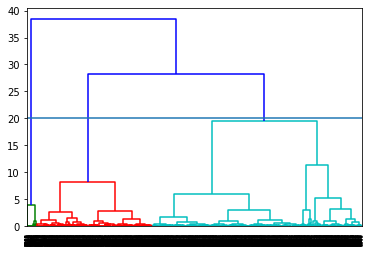

In [28]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=20)

In [29]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
Agg=cluster.fit_predict(sent_vectors)

In [30]:
df_1['AVG-W2V Clus Label'] = cluster.labels_
df_1.head(2)
df_1.groupby(['AVG-W2V Clus Label'])['cleaned_text'].count()

AVG-W2V Clus Label
0     592
1     119
2    1107
3     771
4     128
5     613
6     670
Name: cleaned_text, dtype: int64

In [31]:
for i in range(5):
    print("2 reviews of assigned to cluster ", i)
    print("-" * 70)
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][0]]['cleaned_text'])
    print('\n')
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][1]]['cleaned_text'])
    print('\n')
    print("_" * 70)

2 reviews of assigned to cluster  0
----------------------------------------------------------------------
too small flip make easi use.


guys.......thi phone awesom price, hd screen, good quality, amazing!


______________________________________________________________________
2 reviews of assigned to cluster  1
----------------------------------------------------------------------
bueno


fair


______________________________________________________________________
2 reviews of assigned to cluster  2
----------------------------------------------------------------------
great quality, work perfectli look new.


buy phone look someth least get close physic s (wa realli wanted), turn i love phone. it' great, screen super clear, pictur good, least complet menu, batteri suuuper, depend usag last least hour ... well, i comfort cell work perfect venezuela


______________________________________________________________________
2 reviews of assigned to cluster  3
-------------------------

The DBSCAN can handle in any event, missing qualities in the informational index. Hierarchial grouping have parcel of commotion. We can say k-implies are ideal and ideal. k-implies bunching is a strategy for vector quantization, initially from signal preparing, that expects to parcel and perceptions into k groups in which every perception has a place with the group with the closest mean, filling in as a model of the group. we can see from the outcome that k-implies are straightforward than DBSCAN.

------------EOF---------------